In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id, F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType
from pyspark.sql.functions import hour, col, count, avg
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
spark = SparkSession.builder.appName("FinalProject").getOrCreate()


24/12/04 09:07:46 WARN Utils: Your hostname, pwg resolves to a loopback address: 127.0.1.1; using 192.168.0.14 instead (on interface wlo1)
24/12/04 09:07:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/04 09:07:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/04 09:07:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
green = spark.read.csv("merged_green_file.csv", header=True, inferSchema=True)
green = green.fillna(0)
green.show(3)

+--------+--------------------+---------------------+---------------+-------------+------------+------------+----------+------------------+------------+-----------+-----+-------+---------------------+----------+------------+------------+---------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|improvement_surcharge|tip_amount|tolls_amount|total_amount|trip_type|
+--------+--------------------+---------------------+---------------+-------------+------------+------------+----------+------------------+------------+-----------+-----+-------+---------------------+----------+------------+------------+---------+
|       2| 2014-10-08 23:25:12|  2014-10-08 23:29:41|            1.0|         0.91|         255|         112|       1.0|                 N|         1.0|        5.5|  0.5|    0.5|                  0.0|       1.5|         0.0|         8.0|      1.0|
|       

In [5]:
yellow = spark.read.csv("merged_yellow_file.csv", header=True, inferSchema=True)
yellow = yellow.fillna(0)   
yellow.show(3)

+--------+--------------------+---------------------+---------------+-------------+------------+------------+----------+------------------+------------+-----------+-----+-------+---------------------+----------+------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|improvement_surcharge|tip_amount|tolls_amount|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+------------+------------+----------+------------------+------------+-----------+-----+-------+---------------------+----------+------------+------------+--------------------+-----------+
|       1| 2014-10-28 16:27:45|  2014-10-28 16:31:06|            1.0|          0.4|         164|         161|       1.0|                 N|           2|        4.0|  1.0|    0.5|         

In [6]:
print(green.dtypes)


[('VendorID', 'int'), ('lpep_pickup_datetime', 'timestamp'), ('lpep_dropoff_datetime', 'timestamp'), ('passenger_count', 'double'), ('trip_distance', 'double'), ('PULocationID', 'int'), ('DOLocationID', 'int'), ('RatecodeID', 'double'), ('store_and_fwd_flag', 'string'), ('payment_type', 'double'), ('fare_amount', 'double'), ('extra', 'double'), ('mta_tax', 'double'), ('improvement_surcharge', 'double'), ('tip_amount', 'double'), ('tolls_amount', 'double'), ('total_amount', 'double'), ('trip_type', 'double')]


In [7]:
print(yellow.dtypes)


[('VendorID', 'int'), ('tpep_pickup_datetime', 'timestamp'), ('tpep_dropoff_datetime', 'timestamp'), ('passenger_count', 'double'), ('trip_distance', 'double'), ('PULocationID', 'int'), ('DOLocationID', 'int'), ('RatecodeID', 'double'), ('store_and_fwd_flag', 'string'), ('payment_type', 'int'), ('fare_amount', 'double'), ('extra', 'double'), ('mta_tax', 'double'), ('improvement_surcharge', 'double'), ('tip_amount', 'double'), ('tolls_amount', 'double'), ('total_amount', 'double'), ('congestion_surcharge', 'double'), ('airport_fee', 'double')]


In [8]:
green = green.withColumn('store_and_fwd_flag', F.when(green['store_and_fwd_flag'] == 'Y', 1).otherwise(0).cast('int'))
green.show(3)

+--------+--------------------+---------------------+---------------+-------------+------------+------------+----------+------------------+------------+-----------+-----+-------+---------------------+----------+------------+------------+---------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|improvement_surcharge|tip_amount|tolls_amount|total_amount|trip_type|
+--------+--------------------+---------------------+---------------+-------------+------------+------------+----------+------------------+------------+-----------+-----+-------+---------------------+----------+------------+------------+---------+
|       2| 2014-10-08 23:25:12|  2014-10-08 23:29:41|            1.0|         0.91|         255|         112|       1.0|                 0|         1.0|        5.5|  0.5|    0.5|                  0.0|       1.5|         0.0|         8.0|      1.0|
|       

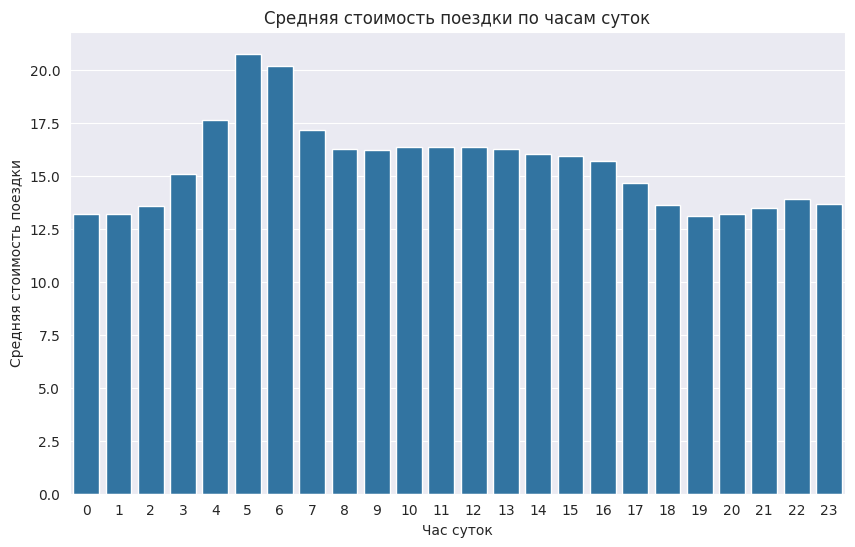

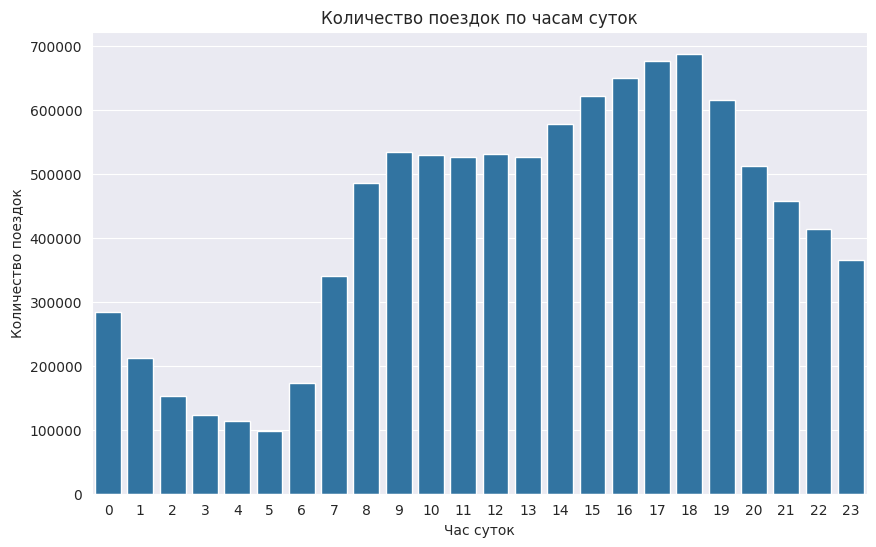

In [ ]:
spark = SparkSession.builder.appName("TaxiDataAnalysis").getOrCreate()

df = spark.read.csv('merged_green_file.csv', header=True, inferSchema=True)

df = df.withColumn('lpep_pickup_datetime', col('lpep_pickup_datetime').cast('timestamp'))
df = df.withColumn('lpep_dropoff_datetime', col('lpep_dropoff_datetime').cast('timestamp'))

df = df.withColumn('trip_duration', (col('lpep_dropoff_datetime').cast('long') - col('lpep_pickup_datetime').cast('long')) / 60)

df = df.filter(col('trip_duration') > 0)

df = df.withColumn('hour', hour(col('lpep_pickup_datetime')))

avg_fare_by_hour = df.groupBy('hour').agg(avg('fare_amount').alias('avg_fare_amount')).orderBy('hour')
avg_fare_by_hour_pd = avg_fare_by_hour.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='hour', y='avg_fare_amount', data=avg_fare_by_hour_pd)
plt.title('Average Trip Fare by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Fare Amount')
plt.show()

trip_count_by_hour = df.groupBy('hour').agg(count('*').alias('trip_count')).orderBy('hour')
trip_count_by_hour_pd = trip_count_by_hour.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='hour', y='trip_count', data=trip_count_by_hour_pd)
plt.title('Number of Trips by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.show()


In [26]:
df = pd.read_csv('greentax/greens1_updated_new.csv')

In [19]:
df_yellow1 = pd.read_csv('yellowtax/yellows1_updated_new.csv')

In [32]:
df= pd.read_csv('merged_green_file.csv')
df['improvement_surcharge'].fillna(0, inplace=True)


/tmp/ipykernel_6858/993689850.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['improvement_surcharge'].fillna(0, inplace=True)


750187
Linear regression - MSE: 36.4215962198988, R²: 0.6260343516493581
Random Forest - MSE: 33.865183518662114, R²: 0.6522828040098145


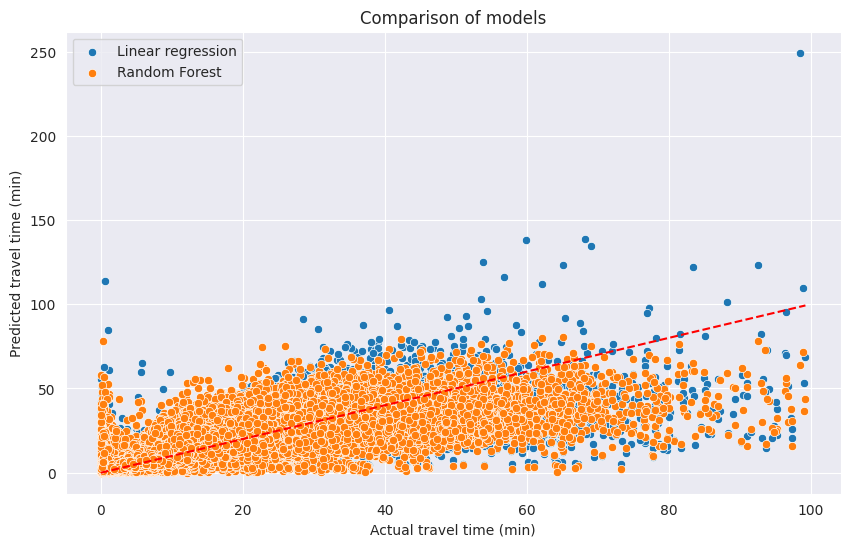

In [ ]:
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])

df['trip_duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60

df = df[(df['trip_duration'] >= 0) & (df['trip_duration'] <= 100)]
print(f'{len(df)}')


df['pickup_hour'] = df['lpep_pickup_datetime'].dt.hour
df['pickup_day'] = df['lpep_pickup_datetime'].dt.dayofweek

features = ['trip_distance', 'passenger_count', 'pickup_hour', 'pickup_day']
target = 'trip_duration'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Linear regression - MSE: {mse_lr}, R²: {r2_lr}')
print(f'Random Forest - MSE: {mse_rf}, R²: {r2_rf}')

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_lr, label='Linear regression')
sns.scatterplot(x=y_test, y=y_pred_rf, label='Random Forest')
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual travel time (min)')
plt.ylabel('Predicted travel time (min)')
plt.title('Comparison of models')
plt.legend()
plt.show()

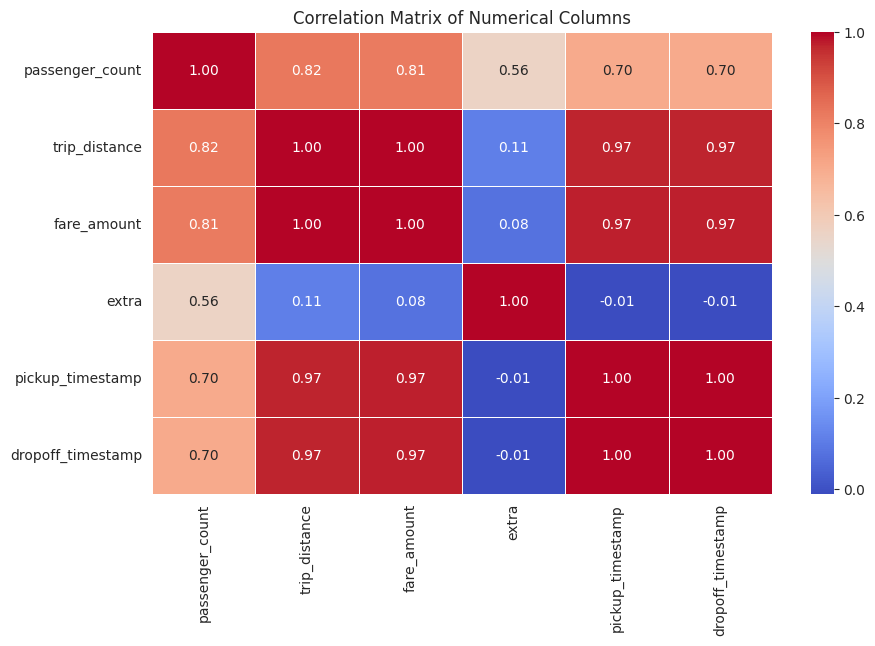

In [ ]:


df.columns = df.columns.str.strip()

numerical_columns = ['passenger_count', 'trip_distance', 'fare_amount', 'extra', 
                     'pickup_timestamp', 'dropoff_timestamp']

df_numeric = df[numerical_columns]

correlation_matrix = df_numeric.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation Matrix of Numerical Columns')

plt.show()


In [16]:
print(df.dtypes)


VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
fare_amount                     float64
extra                           float64
pickup_timestamp                float64
dropoff_timestamp               float64
dtype: object


In [2]:
df_yellow= pd.read_csv('merged_yellow_file.csv')


In [4]:
df_yellow.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID',
       'RatecodeID', 'store_and_fwd_flag', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'improvement_surcharge', 'tip_amount',
       'tolls_amount', 'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

Linear regression - MSE: 32.61997790463071, R²: 0.6820562562677066
Random Forest - MSE: 7.62542337076765, R²: 0.9256757419905727


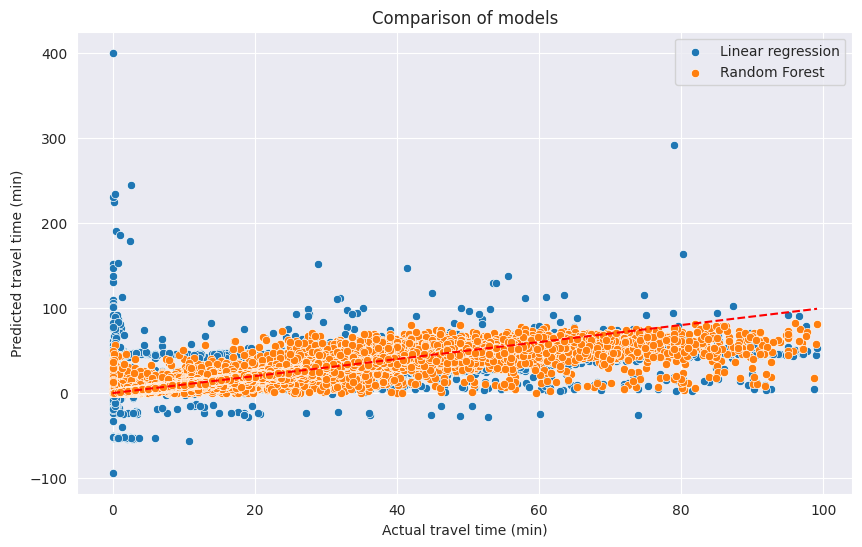

In [ ]:


df_yellow = df_yellow.head(1000000) 

df_yellow['tpep_pickup_datetime'] = pd.to_datetime(df_yellow['tpep_pickup_datetime'])
df_yellow['tpep_dropoff_datetime'] = pd.to_datetime(df_yellow['tpep_dropoff_datetime'])

df_yellow['trip_duration'] = (df_yellow['tpep_dropoff_datetime'] - df_yellow['tpep_pickup_datetime']).dt.total_seconds() / 60

df_yellow = df_yellow[(df_yellow['trip_duration'] >= 0) & (df_yellow['trip_duration'] <= 100)]

df_yellow['pickup_hour'] = df_yellow['tpep_pickup_datetime'].dt.hour
df_yellow['pickup_day'] = df_yellow['tpep_pickup_datetime'].dt.dayofweek

features = ['trip_distance', 'passenger_count', 'pickup_hour', 'pickup_day', 'fare_amount', 'extra', 
            'mta_tax', 'improvement_surcharge', 'tip_amount', 'tolls_amount', 'total_amount', 
            'congestion_surcharge', 'airport_fee']
target = 'trip_duration'

X = df_yellow[features]
y = df_yellow[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Linear regression - MSE: {mse_lr}, R²: {r2_lr}')
print(f'Random Forest - MSE: {mse_rf}, R²: {r2_rf}')

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_lr, label='Linear regression')
sns.scatterplot(x=y_test, y=y_pred_rf, label='Random Forest')
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual travel time (min)')
plt.ylabel('Predicted travel time (min)')
plt.title('Comparison of models')
plt.legend()
plt.show()


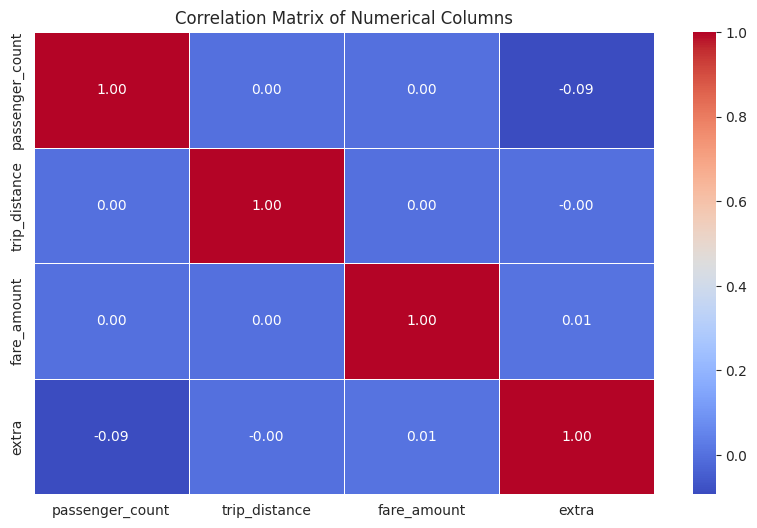

In [ ]:
df_yellow.columns = df_yellow.columns.str.strip()

numerical_columns = ['passenger_count', 'trip_distance', 'fare_amount', 'extra']

df_numeric = df_yellow[numerical_columns]

correlation_matrix = df_numeric.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation Matrix of Numerical Columns')

plt.show()
